In [5]:
import os
os.chdir('../../modules/')

In [6]:
import pickle
from util.util import *
from util.losses import *
from util.pred_blocks import ConvEncoder, GRUDecoder
from likelihood_predictor import PlastPredictor
from vae_generator import PlastVAEGen
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [7]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

In [8]:
# Load Data
pl_ll = pd.read_pickle('../database/vae_pl.pkl')
org_ll = pd.read_pickle('../database/vae_org.pkl')
orgpl_test = pd.read_pickle('../database/vae_orgpl.pkl').to_numpy()
orgpl_sample = pd.read_pickle('../database/vae_orgpl.pkl').sample(n=500).to_numpy()
gdb_data = pd.read_pickle('../database/gdb_vae_test_1mil.pkl').to_numpy()
gdb_test = pd.read_pickle('../database/gdb_vae_test_1mil.pkl').sample(n=500).to_numpy()
all_data = pd.concat([pl_ll, org_ll]).to_numpy()
test_data = pd.concat([pl_ll, org_ll]).sample(n=500).to_numpy()

### Evaluating model reconstruction

In [9]:
char_weights_gdb = np.load('util/char_weights_gdb.npy')
char_weights_orgpl = np.load('util/char_weights_orgpl.npy')
with open('util/char_dict.pkl', 'rb') as f:
    char_dict = pickle.load(f)
with open('util/org_dict.pkl', 'rb') as f:
    org_dict = pickle.load(f)

In [10]:
params={'MAX_LENGTH': 180,
        'BATCH_SIZE': 10,
        'MODEL_CLASS': 'GRUGRU',
        'ARCH_SIZE': 'large',
        'CHAR_DICT': char_dict,
        'ORG_DICT': org_dict,
        'CHAR_WEIGHTS': char_weights_orgpl}

In [11]:
ckpt_fn = 'latest_GRUGRU_transfer_1mil.ckpt'

pvg = PlastVAEGen(params=params, name='test')
pvg.load(os.path.join('checkpoints', ckpt_fn), transfer=False, predict_property=False)
pvg.initiate(orgpl_test)

In [12]:
train_smiles = np.array(pvg.usable_smiles)[pvg.params['TRAIN_IDXS']]
val_smiles = np.array(pvg.usable_smiles)[pvg.params['VAL_IDXS']]

In [13]:
X_train = pvg.encoded[pvg.params['TRAIN_IDXS'],:]
X_val = pvg.encoded[pvg.params['VAL_IDXS'],:]

In [14]:
def get_smiles(idx, set='train', temp=0.1, encoded=False):
    if set == 'train':
        encoded_smile = X_train[idx,:]
        in_smile = train_smiles[idx]
    elif set == 'val':
        encoded_smile = X_val[idx,:]
        in_smile = val_smiles[idx]
    decoded_smile_for_loss = pvg.predict(encoded_smile.unsqueeze(0).numpy())[0,:]
    print(decoded_smile_for_loss.shape)
    decoded_smile = F.softmax(torch.tensor(decoded_smile_for_loss), dim=0).numpy()
    out_smile = decode_smiles(decoded_smile, pvg.params['ORG_DICT'], temp=temp)
    if encoded:
        return encoded_smile.unsqueeze(0), torch.tensor(decoded_smile_for_loss).unsqueeze(0)
    else:
        return in_smile, out_smile

In [15]:
for idx in range(10):
    in_smile, out_smile = get_smiles(idx, set='val', temp=0.02)
    print('-----Index {}-----'.format(idx+1))
    print('Target ', ''.join(in_smile))
    print('Output ', out_smile)

(23, 180)
-----Index 1-----
Target  CCCCC(CC)COC(=O)CCCCCC(C)C__________________________________________________________________________________________________________________________________________________________
Output  CCCCC(CC)COC(=O)CCCCCC(C)C__________________________________________________________________________________________________________________________________________________________
(23, 180)
-----Index 2-----
Target  CC(C)COP(=O)(OCC(C)C)OCC(C)C________________________________________________________________________________________________________________________________________________________
Output  CC(C)COP(=O)(OCC(C)C)OCC(C)C________________________________________________________________________________________________________________________________________________________
(23, 180)
-----Index 3-----
Target  CCCCOP(=O)(OCCCC)OCCCC__________________________________________________________________________________________________________________________________

Almost good enough!

In [813]:
enc, dec = get_smiles(0, set='train', temp=0.05, encoded=True)
ce_loss(enc, dec)

tensor(0.2826)

In [814]:
def enc_to_class(x):
    x = x.permute(0, 2, 1)
    x = x.contiguous().view(-1, x.size(2))
    _, x = torch.max(x, 1)
    return x

def reform_dec(x):
    x = x.permute(0, 2, 1)
    x = x.contiguous().view(-1, x.size(2))
    return x

def loss_per_char(enc, dec, verbose=False):
    x = enc_to_class(enc)
    y = reform_dec(dec)

    loss = 0
    losses = []
    for i in range(y.shape[0]):
        l = -y[i,x[i]]
        exp_sum = 0
        for j in range(y.shape[1]):
            exp_sum += np.exp(y[i,j])
        l += np.log(exp_sum)
        losses.append(l)
        if verbose:
            print(l, x[i], F.softmax(y[i,:]).numpy()[x[i]])
        loss += l
    loss /= pvg.params['MAX_LENGTH']
    return loss, losses
loss, losses = loss_per_char(enc, dec, verbose=False)
loss

tensor(0.2826)

## Notes

### KL_BETA Introduction

This loss function is not good enough. It provides too much reward for basically random guessing (has 1/num_char chance of guessing "right" for all null characters). Need to use cross entropy. Back to where we were before experiments with v2 and bce_loss. 

I think repeat vector may be a culprit in the models inability to generalize. The latent space is size batch_sizexlatent_size and is repeated along the sequence dimension aka if the sequence length is 60 then 60 copies of this latent space vector are sent to the GRU. Idk how the network is supposed to learn sequence when the input sequence has identical elements. Gonna try and add a nonlinearity between latent space and input of GRU.

### Adding Latent Non-Linearity

The loss is the best that I've achieved so far with, on average, a greater than 20x chance of selecting better than random for both the training set and validation set. However, the model still cannot adequately reconstruct SMILES from the latent vector.
```
-----Index 1-----
Input  CC1C2CN=C1OC1=C(NC(N)=N2)N=C(O)N1
Target CC1CCCCCCCCCC=C(CC(O)=N2)N=C(O)N1___________________________
-----Index 2-----
Input  CC12CCCC3=C(C=NN3)C(CO1)NC2C#C
Target CC1CCCCCCCC(CCCC))C(C#N)C2=C=O______________________________
-----Index 3-----
Input  CC1CC(CN1)C1NC2=NCC3CCC1C23O
Target CC1CCCCCCCCCCCCCCCCCCCCCC24C________________________________
-----Index 4-----
Input  CC(O)C(C)(C)C1C2OC(C2O)C(C)C1C
Target CC1CCCCCC(CC)CCC=C(C#C)C(C)C1C______________________________
-----Index 5-----
Input  CCCNCC1OC(C#N)C(N)C2COC1O2
Target CC1CCCCCCCC(O)C(C)CCCCCOCC1_________________________________
-----Index 6-----
Input  CC1=COC(=N)C(NC=N)=NC=CC(C=O)=N1
Target CC1CCCCCCCCC(NC=O)=CCCCC(C=O)=N1____________________________
-----Index 7-----
Input  CCCC1=C(CC(N)(CO)C#C)NN=C1C#N
Target CC1CCCCCCCCCC(C)CCCC)CC=C(C#N_______________________________
-----Index 8-----
Input  CC1(O)COCOC1C1CNC1CC=O
Target CC1CCCCCCCCCC=CCCCCCCCC_____________________________________
-----Index 9-----
Input  CC1C(O)C2(C)CC1C(N)=NC(CO)(C2)C#N
Target CC1CCCCCC(=)C1=C(C)CCC(=O)(C1)C=N___________________________
-----Index 10-----
Input  CC12CC(CC#N)CNCC1(CO)CNC=N2
Target CC1CCCCCCCCCCCCCC(CO)CCC=N2_________________________________
```
The model is actually doing a fairly good job predicting sequence except for a small group of characters towards the beginning. It thinks every SMILE should start with `CC1CCCC...`.

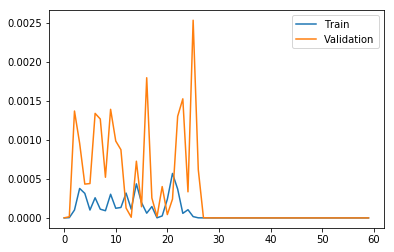

In [30]:
# Code to calculate avg train and val losses per character position (takes a really long time)
# stride = 100
# train_losses = np.zeros((pvg.params['N_TRAIN'] // stride, pvg.params['MAX_LENGTH']))
# val_losses = np.zeros((pvg.params['N_TEST'] // stride, pvg.params['MAX_LENGTH']))

# for i in range(pvg.params['N_TRAIN']):
#     j = 0
#     if i % stride == 0:
#         enc, dec = get_smiles(i, set='train', temp=0.05, encoded=True)
#         loss, losses = loss_per_char(enc, dec, verbose=False)
#         train_losses[j,:] = losses
#         j += 1

# for i in range(pvg.params['N_TEST']):
#     j = 0
#     if i % stride == 0:
#         enc, dec = get_smiles(i, set='test', temp=0.05, encoded=True)
#         loss, losses = loss_per_char(enc, dec, verbose=False)
#         val_losses[j,:] = losses
#         j += 1
# avg_train_losses = np.mean(train_losses, axis=0)
# avg_val_losses = np.mean(val_losses, axis=0)

avg_train_losses = np.load('run_data/latent_nonlin/avg_train_losses.npy')
avg_val_losses = np.load('run_data/latent_nonlin/avg_val_losses.npy')
plt.plot(avg_train_losses, label='Train')
plt.plot(avg_val_losses, label='Validation')
plt.legend(loc='best')
plt.show()

The average loss per character doesn't really show any trends that would indicate the model predicts the same starting characters every time. It must have to do with the distribution of characters at each position in the training set.

In [31]:
# # Code to generate character count dictionary (takes a while)
# char_dist = {}
# for k in pvg.params['CHAR_DICT'].keys():
#     char_dist[k] = np.zeros((pvg.params['MAX_LENGTH']+1,))
# for smile in train_smiles:
#     for i, char in enumerate(smile):
#         char_dist[char][i] += 1
#         char_dist[char][-1] += 1
#     for j in range(i, pvg.params['MAX_LENGTH']):
#         char_dist['_'][j] += 1
#         char_dist['_'][-1] += 1

with open('run_data/latent_nonlin/char_dist.pkl', 'rb') as f:
    char_dist = pickle.load(f)

In [32]:
# # Code to generate validation character count dictionary (takes a really long time)
# val_char_dist = {}
# for k in pvg.params['CHAR_DICT'].keys():
#     val_char_dist[k] = np.zeros((pvg.params['MAX_LENGTH']+1,))
# for idx in range(pvg.params['N_TRAIN']):
#     in_smile, out_smile = get_smiles(idx, set='train', temp=0.05)
#     for i, char in enumerate(out_smile):
#         val_char_dist[char][i] += 1
#         val_char_dist[char][-1] += 1
#     for j in range(i, pvg.params['MAX_LENGTH']):
#         val_char_dist['_'][j] += 1
#         val_char_dist['_'][-1] += 1

with open('run_data/latent_nonlin/val_char_dist.pkl', 'rb') as f:
    val_char_dist = pickle.load(f)

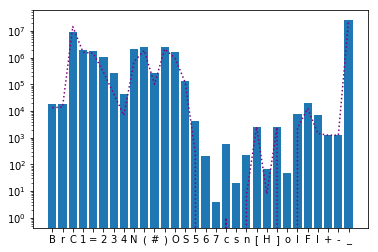

In [33]:
all_chars = np.zeros((30,))
all_val_chars = np.zeros((30,))
char_labels = []
i = 0
for k, v in char_dist.items():
    char_labels.append(k)
    all_chars[i] = v[-1]
    all_val_chars[i] = val_char_dist[k][-1]
    i += 1
plt.bar(range(len(all_chars)), all_chars)
plt.plot(all_val_chars, c='purple', ls=':')
plt.xticks(range(len(all_chars)), labels=char_labels)
plt.yscale('log')
plt.show()

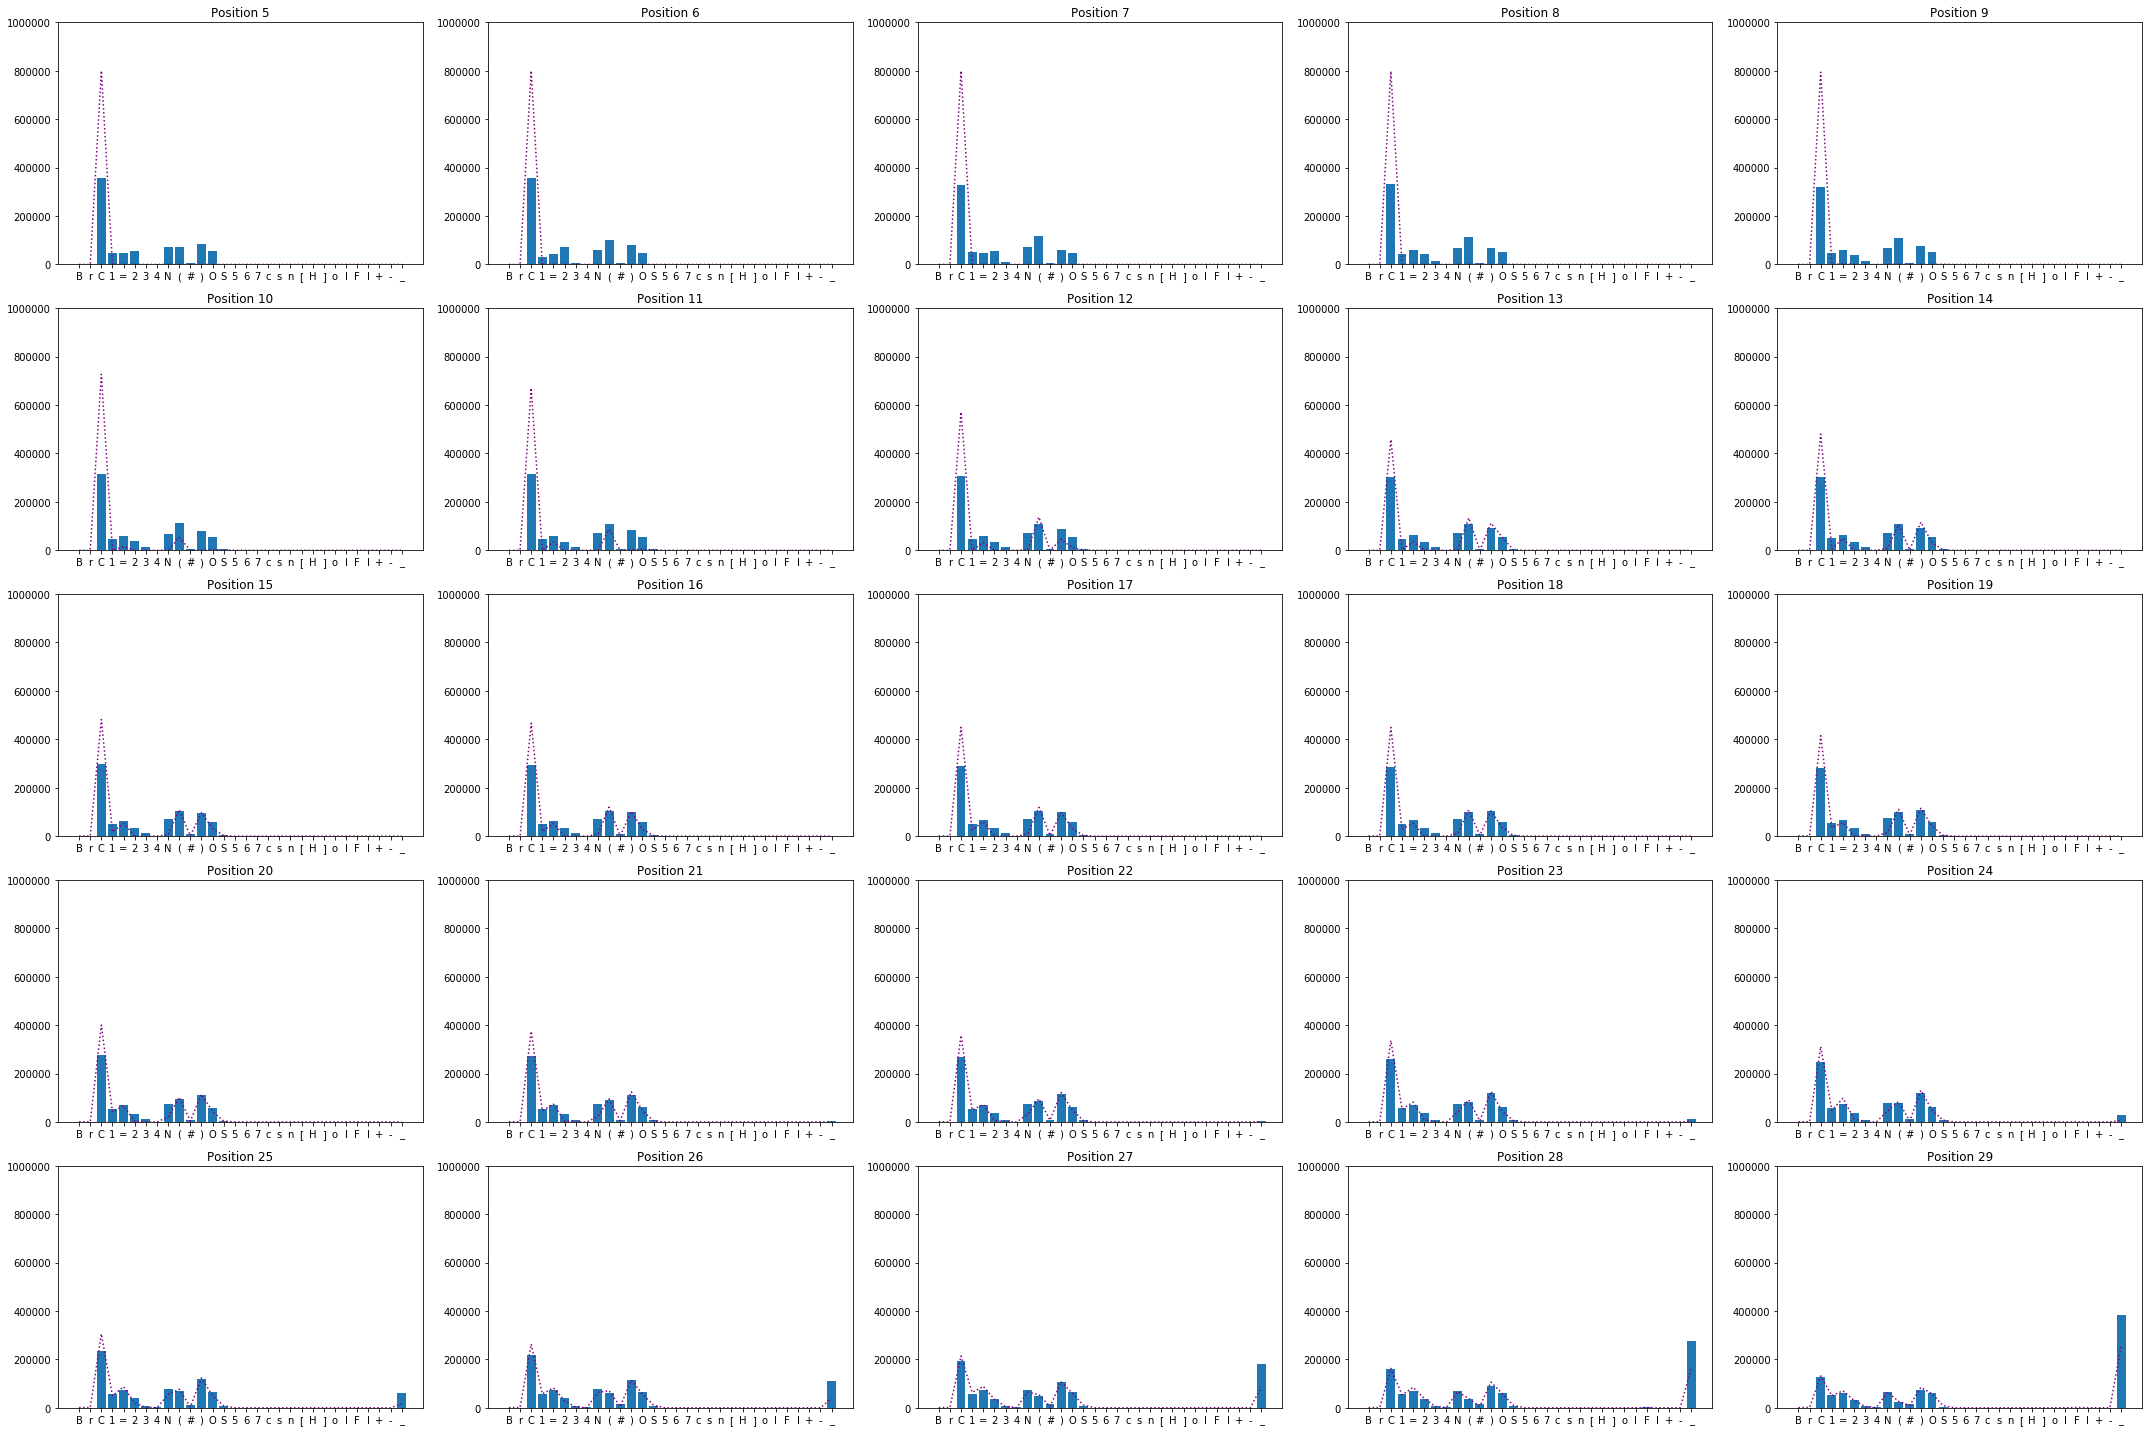

In [37]:
# fig, axs = plt.subplots(10, 6, figsize=(30,20))
# plt.setp(axs, xticks=range(len(all_chars)), xticklabels=char_labels)

# for i, ax in enumerate(fig.axes):
#     position_chars = np.zeros((30,))
#     val_pos_chars = np.zeros((30,))
#     j = 0
#     for k, v in char_dist.items():
#         position_chars[j] = v[i]
#         val_pos_chars[j] = val_char_dist[k][i]
#         j += 1
#     ax.bar(range(len(position_chars)), position_chars)
#     ax.plot(val_pos_chars, c='purple', ls=':')
#     ax.set_title('Position {}'.format(i+1))
#     ax.set_ylim([0,1e6])
# fig.tight_layout()
# plt.show()

fig, axs = plt.subplots(5, 5, figsize=(30,20))
plt.setp(axs, xticks=range(len(all_chars)), xticklabels=char_labels)

for i, ax in enumerate(fig.axes):
    position_chars = np.zeros((30,))
    val_pos_chars = np.zeros((30,))
    j = 0
    for k, v in char_dist.items():
        position_chars[j] = v[i+4]
        val_pos_chars[j] = val_char_dist[k][i+4]
        j += 1
    ax.bar(range(len(position_chars)), position_chars)
    ax.plot(val_pos_chars, c='purple', ls=':')
    ax.set_title('Position {}'.format(i+5))
    ax.set_ylim([0,1e6])
fig.tight_layout()
plt.show()

The model predictions are fit well when the data is evenly distributed (or a single peak) but struggles when one class dominates while others are still present in smaller numbers. I also now realize how many extra unnecessary padding characters I've been adding. I think the obvious first step is to add weights to each class so the loss is reduced for classes that are dominating. This will not take character position into account so I may have to later account for the distribution within specific positions. I also switched from single characters to regex patterns so, for instance, `B` and `r` are no longer considered separate characters but rather a single `Br` token.

### Weighing Loss by Character Token

Adding a reduction in importance to the loss generated from the most frequent characters had a vast improvement on the model's ability to reconstruct the initial sequence of tokens.
```
-----Index 1-----
Target  CCC1CC(O)C(O)(C#C)C2(CO)NC=NC12______________
Output  CCCCC(C)CC(O)(C#C)C(CCO)NC=NC12______________
-----Index 2-----
Target  CC1=C2C3C(C1)N3C1=C2C(O)=CC(C)=C1N___________
Output  CC1CCC3=C(N1)N1C1=C3C(O)CCC(C)=C1N___________
-----Index 3-----
Target  CC12C(O)CCCC(N=CN)C1=CNC2=O__________________
Output  CCCCC(C)CCCC(N=CN)C1=CNC2=O__________________
-----Index 4-----
Target  CC1C2CC2(CN1C=O)C(N)C1=COC=N1________________
Output  CC1CCCCC(CC1C=O)C(N)C1=COC=N1________________
-----Index 5-----
Target  CC#CC12C(C)CN1CC(C)(C#C)C2(C)O_______________
Output  CC1CCCCC(C)C11CC(C)(OC=)C2(C)O_______________
-----Index 6-----
Target  CC1C2CC2(O)C(C(C)=O)=C1CNC=N_________________
Output  CC1CCCCC(O)C(C(C)=O)=C1CNC=N_________________
-----Index 7-----
Target  CC1CN(CC(O)(CO)C#N)C2=CON=C2C1_______________
Output  CCCCCCCC(O)(CO)C#N)C2=CON=C2N1_______________
-----Index 8-----
Target  CC1NC2CC1(C)C1CN=C(CCC(N)C2)N1_______________
Output  CC1CCC2CC(C)C1CN=C(CCC(N)N=)S1_______________
-----Index 9-----
Target  CC(C)(OC1=NC(CO)CN1)C(C=O)C(N)=N_____________
Output  CC((O)NC1=NC(CO=CN1)C(CNO)C(N)=O_____________
-----Index 10-----
Target  CCNC1(CC(CC=C1)=NO)C(C)(O)CNC________________
Output  CC1CCCCC(CC=C1)=NO)C(C)(O)CNC_C______________
```
Additionally, both the validation and training losses were continuing to decrease as of 180 epochs. Further gains may be seen by simply training the model for an additional period of time. Before I do any more hyper-parameter tuning I want to make sure the `ConvGRU` architecture is the best for this task. I plan on comparing it to a `GRUGRU` style architecture with different combinations of bi-directionality.

In [47]:
# Code to generate character count dictionary (takes a while)
char_dist = {}
for k in pvg.params['CHAR_DICT'].keys():
    char_dist[k] = np.zeros((pvg.params['MAX_LENGTH']+1,))
for smile in train_smiles:
    for i, char in enumerate(smile):
        char_dist[char][i] += 1
        char_dist[char][-1] += 1
    for j in range(i, pvg.params['MAX_LENGTH']):
        char_dist['_'][j] += 1
        char_dist['_'][-1] += 1

In [51]:
# Code to generate validation character count dictionary (takes a really long time)
stride = 1000
val_char_dist = {}
for k in pvg.params['CHAR_DICT'].keys():
    val_char_dist[k] = np.zeros((pvg.params['MAX_LENGTH']+1,))
for idx in range(0, pvg.params['N_TRAIN'], stride):
    in_smile, out_smile = get_smiles(idx, set='train', temp=0.05)
    out_smile = smi_tokenizer(out_smile)
    for i, char in enumerate(out_smile):
        val_char_dist[char][i] += 1
        val_char_dist[char][-1] += 1
    for j in range(i, pvg.params['MAX_LENGTH']):
        val_char_dist['_'][j] += 1
        val_char_dist['_'][-1] += 1

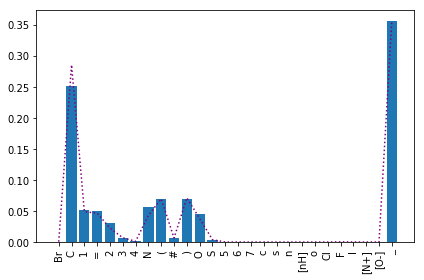

In [59]:
all_chars = np.zeros((27,))
all_val_chars = np.zeros((27,))
char_labels = []
all_normalizer = 0
val_normalizer = 0
for k, v in char_dist.items():
    all_normalizer += v[-1]
    val_normalizer += val_char_dist[k][-1]

i = 0
for k, v in char_dist.items():
    char_labels.append(k)
    all_chars[i] = v[-1] / all_normalizer
    all_val_chars[i] = val_char_dist[k][-1] / val_normalizer
    i += 1
plt.bar(range(len(all_chars)), all_chars)
plt.plot(all_val_chars, c='purple', ls=':')
plt.xticks(range(len(all_chars)), labels=char_labels, rotation='vertical')
plt.tight_layout()
plt.show()

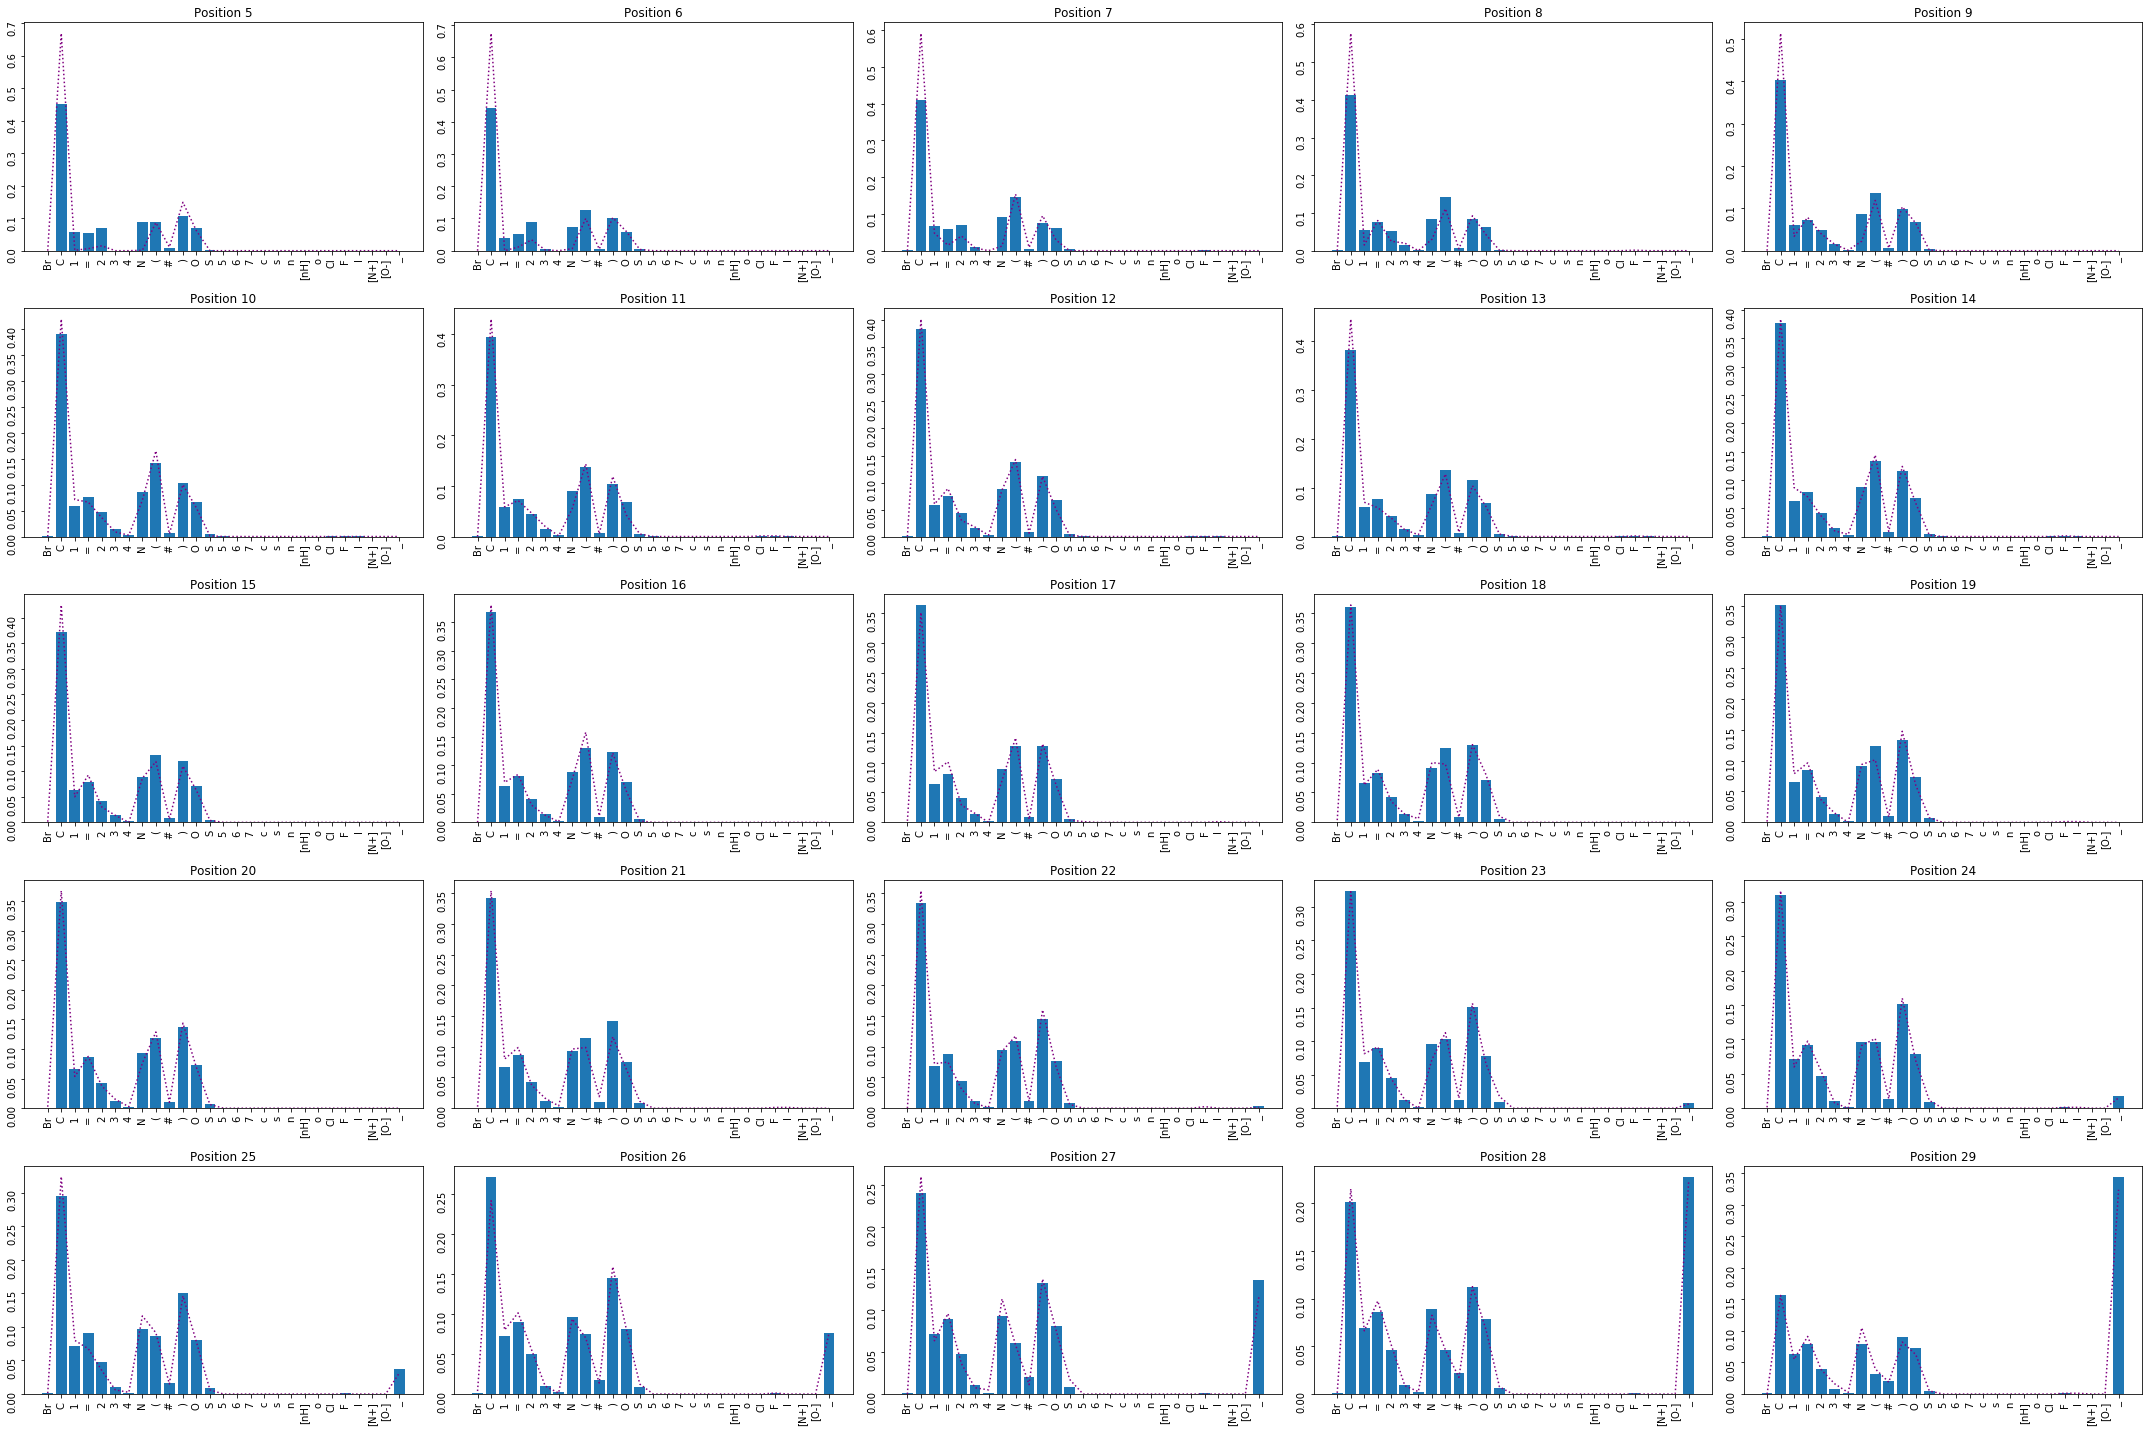

In [61]:
fig, axs = plt.subplots(5, 5, figsize=(30,20))
plt.setp(axs, xticks=range(len(all_chars)), xticklabels=char_labels)

for i, ax in enumerate(fig.axes):
    position_chars = np.zeros((27,))
    val_pos_chars = np.zeros((27,))
    all_normalizer = 0
    val_normalizer = 0
    for k, v in char_dist.items():
        all_normalizer += v[i+4]
        val_normalizer += val_char_dist[k][i+4]
    
    j = 0
    for k, v in char_dist.items():
        position_chars[j] = v[i+4] / all_normalizer
        val_pos_chars[j] = val_char_dist[k][i+4] / val_normalizer
        j += 1
    ax.bar(range(len(position_chars)), position_chars)
    ax.plot(val_pos_chars, c='purple', ls=':')
    ax.tick_params(labelrotation=90)
    ax.set_title('Position {}'.format(i+5))
fig.tight_layout()
plt.show()

### Exploring Model Architectures

In [15]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [64]:
model_classes = ['ConvGRU', 'ConvbiGRU', 'GRUGRU', 'biGRUGRU', 'biGRUbiGRU']
num_params = []
for model_class in model_classes:
    max_len = 45
    pvg = PlastVAEGen(params={'MAX_LENGTH': max_len, 
                              'N_EPOCHS': 10, 
                              'BATCH_SIZE': 10, 
                              'MODEL_CLASS': model_class}, weigh_freq=False)
    pvg.initiate(gdb_test)
    num_params.append(count_parameters(pvg.network))

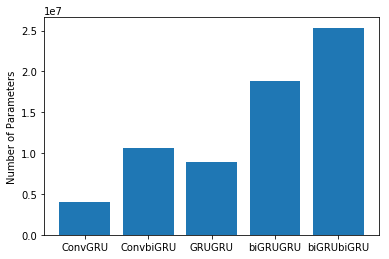

In [65]:
plt.bar(range(len(num_params)), num_params)
plt.xticks(range(len(num_params)), labels=model_classes)
plt.ylabel('Number of Parameters')
plt.show()

GRUs are expensive relative to convolutional layers and even more so when bi-directionality is added. The additional model complexity should be considered when comparing the performance of these architectures.

In [28]:
max_len = 45
pvg = PlastVAEGen(params={'MAX_LENGTH': max_len, 
                          'N_EPOCHS': 10, 
                          'BATCH_SIZE': 10, 
                          'MODEL_CLASS': 'biGRUbiGRU'}, weigh_freq=False)
pvg.initiate(gdb_test)
count_parameters(pvg.network.encoder), count_parameters(pvg.network.decoder)

(14981614, 10361382)

### Transfer Learning with Plasticizers and PubChem Organics

### Live Model Performance

In [4]:
def loss_goals(m, nc):
    x = m / (nc + m - 1)
    return -np.log(x)

In [771]:
df = pd.read_csv('run_data/logs/log_reduced_len_beta0.1.txt')

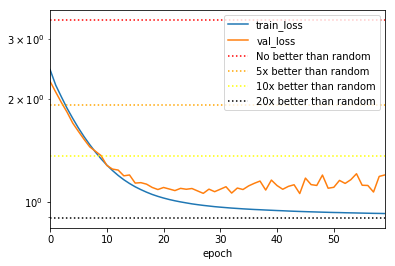

In [772]:
df[df.data_type == 'train'].groupby('epoch').mean()['bce_loss'].plot(label='train_loss')
df[df.data_type == 'test'].groupby('epoch').mean()['bce_loss'].plot(label='val_loss')
plt.axhline(loss_goals(1, 30), c='red', ls=':', label='No better than random')
plt.axhline(loss_goals(5, 30), c='orange', ls=':', label='5x better than random')
plt.axhline(loss_goals(10, 30), c='yellow', ls=':', label='10x better than random')
plt.axhline(loss_goals(20, 30), c='black', ls=':', label='20x better than random')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [309]:
df1 = pd.read_csv('run_data/logs/log_arch_ConvGRU.txt')
df2 = pd.read_csv('run_data/logs/log_arch_ConvbiGRU.txt')
df3 = pd.read_csv('run_data/logs/log_arch_GRUGRU.txt')
df4 = pd.read_csv('run_data/logs/log_arch_biGRUGRU.txt')
df5 = pd.read_csv('run_data/logs/log_arch_biGRUbiGRU.txt')

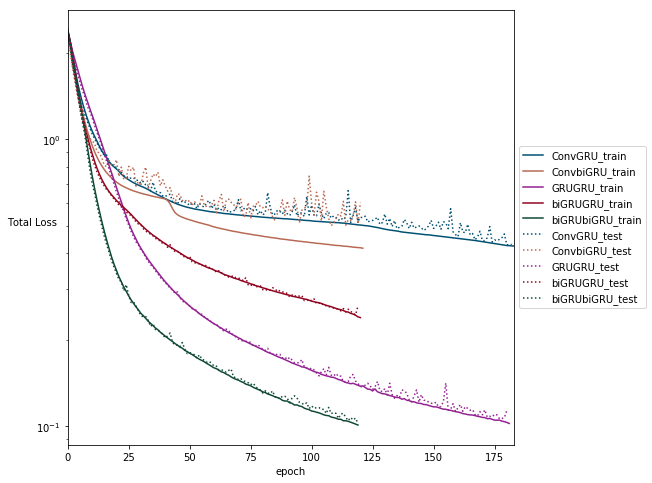

In [310]:
colors = ['#005073', '#B86953', '#932191', '#90041F', '#0F4935']

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

df1[df1.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='ConvGRU_train',
                                                                       c=colors[0])
df2[df2.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='ConvbiGRU_train',
                                                                       c=colors[1])
df3[df3.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='GRUGRU_train',
                                                                       c=colors[2])
df4[df4.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='biGRUGRU_train',
                                                                       c=colors[3])
df5[df5.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='biGRUbiGRU_train',
                                                                       c=colors[4])
df1[df1.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='ConvGRU_test',
                                                                       ls=':',
                                                                       c=colors[0])
df2[df2.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='ConvbiGRU_test',
                                                                       ls=':',
                                                                       c=colors[1])
df3[df3.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='GRUGRU_test',
                                                                       ls=':',
                                                                       c=colors[2])
df4[df4.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='biGRUGRU_test',
                                                                       ls=':',
                                                                       c=colors[3])
df5[df5.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='biGRUbiGRU_test',
                                                                       ls=':',
                                                                       c=colors[4])
# df1[df1.data_type == 'test'].groupby('epoch').mean()['naive_loss'].plot(label='val_loss')
# ax.axhline(loss_goals(1, 27), c='red', ls=':', label='No better than random', alpha=0.5)
# ax.axhline(loss_goals(5, 27), c='orange', ls=':', label='5x better than random', alpha=0.5)
# ax.axhline(loss_goals(10, 27), c='yellow', ls=':', label='10x better than random', alpha=0.5)
# ax.axhline(loss_goals(20, 27), c='green', ls=':', label='20x better than random', alpha=0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylabel('Total Loss', rotation='horizontal')
plt.show()

In [102]:
df1 = pd.read_csv('run_data/logs/log_GRUGRU_pretrain_1mil.txt')
df2 = pd.read_csv('run_data/logs/log_GRUGRU_pretrain_5mil.txt')
df3 = pd.read_csv('run_data/logs/log_GRUGRU_pretrain_10mil.txt')
# df4 = pd.read_csv('run_data/logs/log_GRUGRU_transfer_1mil.txt')
# df5 = pd.read_csv('run_data/logs/log_GRUGRU_transfer_5mil.txt')

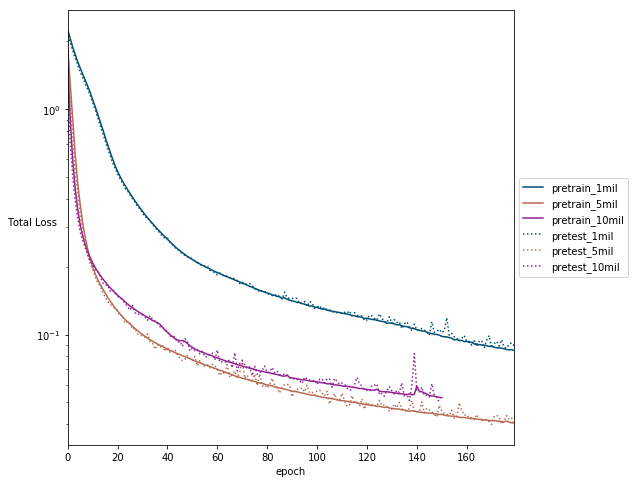

In [103]:
colors = ['#005073', '#B86953', '#932191', '#90041F', '#0F4935']

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

df1[df1.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_1mil',
                                                                       c=colors[0])
df2[df2.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_5mil',
                                                                       c=colors[1])
df3[df3.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_10mil',
                                                                       c=colors[2])
# df4[df4.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='transfer_train_1mil',
#                                                                        c=colors[3])
# df5[df5.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='transfer_train_5mil',
#                                                                        c=colors[4])
df1[df1.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_1mil',
                                                                       ls=':',
                                                                       c=colors[0])
df2[df2.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_5mil',
                                                                       ls=':',
                                                                       c=colors[1])
df3[df3.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_10mil',
                                                                       ls=':',
                                                                       c=colors[2])
# df4[df4.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='transfer_test_1mil',
#                                                                        ls=':',
#                                                                        c=colors[3])
# df5[df5.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='transfer_test_5mil',
#                                                                        ls=':',
#                                                                        c=colors[4])
# df1[df1.data_type == 'test'].groupby('epoch').mean()['naive_loss'].plot(label='val_loss')
# ax.axhline(loss_goals(1, 27), c='red', ls=':', label='No better than random', alpha=0.5)
# ax.axhline(loss_goals(5, 27), c='orange', ls=':', label='5x better than random', alpha=0.5)
# ax.axhline(loss_goals(10, 27), c='yellow', ls=':', label='10x better than random', alpha=0.5)
# ax.axhline(loss_goals(20, 27), c='green', ls=':', label='20x better than random', alpha=0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylabel('Total Loss', rotation='horizontal')
plt.show()

In [16]:
# df1 = pd.read_csv('run_data/logs/log_GRUGRU_prop_pred_1mil.txt')
# df2 = pd.read_csv('run_data/logs/log_GRUGRU_prop_pred_5mil.txt')
df3 = pd.read_csv('run_data/logs/log_GRUGRU_prop_pred_no_pretrain.txt')
df4 = pd.read_csv('run_data/logs/log_GRUGRU_transfer_1mil.txt')
df5 = pd.read_csv('run_data/logs/log_GRUGRU_transfer_5mil.txt')

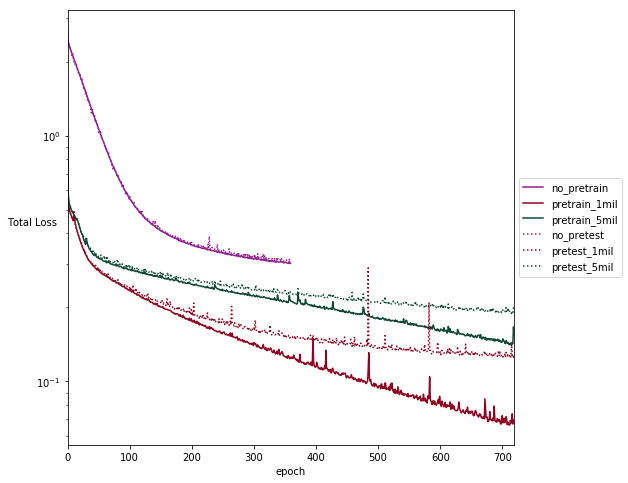

In [17]:
colors = ['#005073', '#B86953', '#932191', '#90041F', '#0F4935']

plt.figure(figsize=(10,8))
ax = plt.subplot(111)

# df1[df1.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_1mil',
#                                                                        c=colors[0])
# df2[df2.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_5mil',
#                                                                        c=colors[1])
df3[df3.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='no_pretrain',
                                                                       c=colors[2])
df4[df4.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_1mil',
                                                                       c=colors[3])
df5[df5.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot(label='pretrain_5mil',
                                                                       c=colors[4])
# df1[df1.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_1mil',
#                                                                        ls=':',
#                                                                        c=colors[0])
# df2[df2.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_5mil',
#                                                                        ls=':',
#                                                                        c=colors[1])
df3[df3.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='no_pretest',
                                                                       ls=':',
                                                                       c=colors[2])
df4[df4.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_1mil',
                                                                       ls=':',
                                                                       c=colors[3])
df5[df5.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot(label='pretest_5mil',
                                                                       ls=':',
                                                                       c=colors[4])
# df1[df1.data_type == 'test'].groupby('epoch').mean()['naive_loss'].plot(label='val_loss')
# ax.axhline(loss_goals(1, 27), c='red', ls=':', label='No better than random', alpha=0.5)
# ax.axhline(loss_goals(5, 27), c='orange', ls=':', label='5x better than random', alpha=0.5)
# ax.axhline(loss_goals(10, 27), c='yellow', ls=':', label='10x better than random', alpha=0.5)
# ax.axhline(loss_goals(20, 27), c='green', ls=':', label='20x better than random', alpha=0.5)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale('log')
plt.ylabel('Total Loss', rotation='horizontal')
plt.show()

### Testing New Models

In [312]:
char_weights_gdb = np.load('util/char_weights_gdb.npy')
char_weights_orgpl = np.load('util/char_weights_orgpl.npy')
with open('util/char_dict.pkl', 'rb') as f:
    char_dict = pickle.load(f)
with open('util/org_dict.pkl', 'rb') as f:
    org_dict = pickle.load(f)

In [286]:
remap_checkpoint('checkpoints/latest_GRUGRU_pretrain_1mil.ckpt', 'checkpoints/latest_GRUGRU_pretrain_1mil_large.ckpt', 'GRUGRU_pretrain_1mil_orgpl')

In [99]:
# Test Model 
small_len = 45
big_len = 180
pvg = PlastVAEGen(params={'MAX_LENGTH': big_len,
                          'BATCH_SIZE': 10,
                          'MODEL_CLASS': 'GRUGRU',
                          'ARCH_SIZE': 'large',
                          'CHAR_DICT': char_dict,
                          'ORG_DICT': org_dict,
                          'CHAR_WEIGHTS': char_weights_orgpl},
                          name='test')

In [100]:
pvg.load('checkpoints/latest_GRUGRU_pretrain_1mil_large.ckpt', transfer=True, predict_property=True)

In [101]:
pvg.train(orgpl_test, epochs=10, save_best=False, save_last=False, log=False, log_latent=False, make_grad_gif=False)

KeyboardInterrupt: 

In [119]:
pvg_big.load('checkpoints/latest_arch_GRUGRU_large.ckpt', transfer=True)

In [92]:
# code for remapping small SMILES train to large?

ckpt_f = torch.load('checkpoints/latest_arch_GRUGRU.ckpt', map_location=torch.device('cpu'))
old_keys = ['encoder.conv2.weight', 'encoder.conv2.bias', 'encoder.conv3.weight', 'encoder.conv3.bias']
new_keys = ['encoder.conv2.0.weight', 'encoder.conv2.0.bias', 'encoder.conv3.0.weight', 'encoder.conv3.0.bias']
for ok, nk in zip(old_keys, new_keys):
    ckpt_f['model_state_dict'][nk] = ckpt_f['model_state_dict'][ok]
    ckpt_f['model_state_dict'].pop(ok)
torch.save(ckpt_f, 'checkpoints/latest_arch_GRUGRU_large.ckpt')

```
RuntimeError: Error(s) in loading state_dict for GRUGRU:
	Missing key(s) in state_dict: "encoder.conv2.0.weight", "encoder.conv2.0.bias", "encoder.conv3.0.weight", "encoder.conv3.0.bias". 
	Unexpected key(s) in state_dict: "encoder.conv2.weight", "encoder.conv2.bias", "encoder.conv3.weight", "encoder.conv3.bias". 
```

In [53]:
pvg_big.params['CHAR_DICT']

{'C': 0,
 '1': 1,
 '=': 2,
 '(': 3,
 ')': 4,
 'O': 5,
 'F': 6,
 'Cl': 7,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 'N': 14,
 '#': 15,
 'S': 16,
 'P': 17,
 '8': 18,
 'Br': 19,
 'I': 20,
 '9': 21,
 '_': 22}

In [101]:
pl_ll.shape, org_ll.shape

((187, 2), (49722, 2))

In [103]:
upsample_ratio = int(org_ll.shape[0] / pl_ll.shape[0])
pl_ll = np.tile(pl_ll, (upsample_ratio, 1))

In [105]:
vae_pl_org = np.concatenate([pl_ll, org_ll])

In [106]:
df = pd.DataFrame(vae_pl_org, columns=['SMILES', 'll'])
df.to_pickle('../database/vae_orgpl.pkl')

In [139]:
gdb_char = ['Br', 'C', '1', '=', '2', '3', '4', 'N', '(', ')', '#', 'O', 'S', '5', 'F', 'Cl', 'I', '_']
pl_char = ['C', '(', ')', 'O', '=', '1', 'P', '2', '3', 'N', 'S', '4', 'Br', 'Cl', '5', '_']
org_char = ['C', 'O', '1', '=', 'N', '(', ')', '2', '3', '4', '5', '6', '7', '8', 'S', 'Cl', '9', '#', 'P', 'F', 'I', '_']
all_char = ['C', 'O', 'N', 'S', 'F', 'P', 'I', 'Cl', 'Br', '1', '2', '3', '4', '5', '6', '7', '8', '9', '#', '=', '(', ')', '_']

In [140]:
all_char_dict, all_ord_dict = {}, {}
for i, char in enumerate(list(all_char)):
    all_char_dict[char] = i
    all_ord_dict[i] = char

In [141]:
all_char_dict

{'C': 0,
 'O': 1,
 'N': 2,
 'S': 3,
 'F': 4,
 'P': 5,
 'I': 6,
 'Cl': 7,
 'Br': 8,
 '1': 9,
 '2': 10,
 '3': 11,
 '4': 12,
 '5': 13,
 '6': 14,
 '7': 15,
 '8': 16,
 '9': 17,
 '#': 18,
 '=': 19,
 '(': 20,
 ')': 21,
 '_': 22}

In [142]:
vae_gdb = pd.read_pickle('../database/vae_gdb.pkl').to_numpy()
all_smiles = np.concatenate([vae_pl_org[:,0], vae_gdb[:,0]])

In [163]:
vae_gdb_test = vae_gdb[np.random.choice(np.arange(vae_gdb.shape[0]), size=1000, replace=False)]

In [146]:
all_smiles = [smi_tokenizer(smi) for smi in all_smiles]

In [147]:
char_weights_gdb = get_char_weights(all_smiles, {'NUM_CHAR': 23,
                                                 'MAX_LENGTH': 45,
                                                 'CHAR_DICT': all_char_dict})
char_weights_orgpl = get_char_weights(all_smiles, {'NUM_CHAR': 23,
                                                   'MAX_LENGTH': 180,
                                                   'CHAR_DICT': all_char_dict})

In [149]:
char_weights_gdb.shape, char_weights_orgpl.shape

((23,), (23,))

In [151]:
np.save('util/char_weights_gdb.npy', char_weights_gdb)
np.save('util/char_weights_orgpl.npy', char_weights_orgpl)
with open('util/char_dict.pkl', 'wb') as f:
    pickle.dump(all_char_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
with open('util/org_dict.pkl', 'wb') as f:
    pickle.dump(all_ord_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [191]:
vae_gdb_1mil = vae_gdb[np.random.choice(np.arange(vae_gdb.shape[0]), size=int(1e6), replace=False)]
vae_gdb_5mil = vae_gdb[np.random.choice(np.arange(vae_gdb.shape[0]), size=int(5e6), replace=False)]
vae_gdb_10mil = vae_gdb[np.random.choice(np.arange(vae_gdb.shape[0]), size=int(1e7), replace=False)]
np.save('../database/vae_gdb_1mil.npy', vae_gdb_1mil)
np.save('../database/vae_gdb_5mil.npy', vae_gdb_5mil)
np.save('../database/vae_gdb_10mil.npy', vae_gdb_10mil)